In [1]:
import tensorflow as tf
import xgboost as xgb
import pandas as pd
import functools
import time
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, \
    auc, average_precision_score, pairwise_distances
import scikitplot as skplt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgb_hyper import objective
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import pickle
import dill
from functools import partial

C:\Users\tomas\miniconda3\envs\binding\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tomas\miniconda3\envs\binding\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tomas\miniconda3\envs\binding\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tomas\miniconda3\envs\binding\lib\site-packages\tensorf

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
print("The following GPU devices ara available: %s"%tf.test.gpu_device_name())

The following GPU devices ara available: /device:GPU:0


In [4]:
def calculate_metrics(y_true, y_pred, plots=False):
    assert isinstance(y_true, np.ndarray), 'y_true should be np.array'
    assert len(y_true.shape) == len(y_pred.shape) == 1, 'y_true or y_pred shapes are not 1 (probably not squeezed)'
    y_pred_bin = y_pred > 0.5

    cf = confusion_matrix(y_true, y_pred_bin)
    tn, fp, fn, tp = cf.ravel()

    metrics = {
        'roc_auc': roc_auc_score(y_true, y_pred),
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'map': average_precision_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred_bin),
        'recall': recall_score(y_true, y_pred_bin),
        'accuracy': accuracy_score(y_true, y_pred_bin),
    }

    if plots:
        print('predictions histogram')
        plt.figure()
        plt.hist(y_pred, bins=int(len(y_pred) / 3))
        plt.show()

        print('confusion matrix')
        plt.figure()
        group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
        group_counts = ['{0:0.0f}'.format(value) for value in
                        cf.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in
                             cf.flatten() / np.sum(cf)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
                  zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2, 2)
        sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
        plt.show()

        print('roc curve')
        random_probs = [0 for _ in range(len(y_true))]
        auc = roc_auc_score(y_true, y_pred)
        print('Logistic: ROC AUC=%.3f' % (auc))
        ns_fpr, ns_tpr, _ = roc_curve(y_true, random_probs)
        lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='random')
        plt.plot(lr_fpr, lr_tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

    return metrics


In [5]:
target = 'akt1'
base_path = f'C:/Users/tomas/Documents/GitHub/kinase_binding'

data_fpath = base_path+f'/data/{target}/data.csv'
df=pd.read_csv(data_fpath).set_index('biolab_index')

with open(base_path+f'/data/{target}/train_val_folds.pkl', "rb") as in_f:
    train_val_folds = dill.load(in_f)
with open(base_path+f'/data/{target}/train_test_folds.pkl', "rb") as in_f:
    train_test_folds = dill.load(in_f)

In [6]:
training_list = [df.loc[train_val_folds[0][0]],
                 df.loc[train_val_folds[1][0]],
                 df.loc[train_val_folds[2][0]],
                 df.loc[train_val_folds[3][0]],
                 df.loc[train_val_folds[4][0]],
                 df.loc[train_val_folds[5][0]],
                 df.loc[train_test_folds[0]]
                 ]
validation_list = [df.loc[train_val_folds[0][1]],
                   df.loc[train_val_folds[1][1]],
                   df.loc[train_val_folds[2][1]],
                   df.loc[train_val_folds[3][1]],
                   df.loc[train_val_folds[4][1]],
                   df.loc[train_val_folds[5][1]],
                   df.loc[train_test_folds[1]]
                   ]

In [7]:
# defining the space
fspace = {
    'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.1, 1), #+
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.1, 1), #+
    'gamma' : hp.uniform('gamma', 0.1, 1), #+
    'learning_rate' : hp.uniform('learning_rate', 0.1, 1),
    'max_delta_step' : hp.quniform('max_delta_step',1,10,1),
    'max_depth' : hp.quniform('max_depth',6, 12, 1),
    'min_child_weight' : hp.quniform('min_child_weight',10 ,500 ,5),
    'reg_alpha' : hp.uniform('reg_alpha',0.1,100),
    'reg_lambda' : hp.uniform('reg_lambda',0.1,100),
    'subsample' : hp.uniform('subsample',0.1,1.0),
    'max_bin' : hp.quniform('max_bin',16,256,16)
    # add sampling method,max bin,predicto,monotone_constraints,interaction_constraints,single_precision_histogram
}

In [8]:
fmin_objective = partial(objective, train_sets = training_list, val_sets = validation_list)

In [9]:
def run_trials():

    trials_step = 0  # how many additional trials to do after loading saved trials. 1 = save after iteration
    max_trials = 1  # initial max_trials. put something small to not have to wait

    
    try:  # try to load an already saved trials object, and increase the max
        trials = pickle.load(open("xgboost.hyperopt", "rb"))
        print("Found saved Trials! Loading...")
        max_trials = len(trials.trials) + trials_step
        print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, trials_step))
    except:  # create a new trials object and start searching
        trials = Trials()

    best = fmin(fn = fmin_objective, space = fspace, algo=tpe.suggest, max_evals=max_trials, trials=trials)

    print("Best:", best)
    
    # save the trials object
    with open("xgboost.hyperopt", "wb") as f:
        pickle.dump(trials, f)
    return(trials)

In [10]:
trials = run_trials()

Found saved Trials! Loading...
Rerunning from 510 trials to 510 (+0) trials
100%|████████████████████████████████████████████████████████████| 510/510 [00:00<00:00, 511378.21trial/s, best loss=?]
Best: {'colsample_bylevel': 0.5612301667238877, 'colsample_bytree': 0.788688363076523, 'gamma': 0.35376030016117566, 'learning_rate': 0.4023692255888918, 'max_bin': 16.0, 'max_delta_step': 3.0, 'max_depth': 8.0, 'min_child_weight': 70.0, 'reg_alpha': 0.15030685758880047, 'reg_lambda': 15.311721955443915, 'subsample': 0.8303923929525608}


In [11]:
best_loss = trials.trials[0]['result']['loss']
for i in range(1,len(trials.trials)):
    if (trials.trials[i]['result']['loss'] <=  best_loss):
        best_loss = trials.trials[i]['result']['loss']
        index = i

    
best_params = trials.trials[index]['misc']['vals']
hyper_params = {
        "colsample_bylevel" : best_params['colsample_bylevel'][0],
        "colsample_bytree" : best_params['colsample_bytree'][0],
        "gamma" : best_params['gamma'][0],
        "eta" : best_params['learning_rate'][0],
        "max_delta_step" : int(best_params['max_delta_step'][0]),
        "max_depth" : int(best_params['max_depth'][0]),
        "min_child_weight" : int(best_params['min_child_weight'][0]),
        "alpha" : best_params['reg_alpha'][0],
        "lambda" : best_params['reg_lambda'][0],
        "subsample" : best_params['subsample'][0],
        "eval_metric":'auc',
        "objective":'binary:logistic',
        "booster":'gbtree',
        "tree_method" : 'gpu_hist',
        "single_precision_histogram" : True
}

In [24]:
hyper_params

{'colsample_bylevel': 0.5612301667238877,
 'colsample_bytree': 0.788688363076523,
 'gamma': 0.35376030016117566,
 'eta': 0.4023692255888918,
 'max_delta_step': 3,
 'max_depth': 8,
 'min_child_weight': 70,
 'alpha': 0.15030685758880047,
 'lambda': 15.311721955443915,
 'subsample': 0.8303923929525608,
 'eval_metric': 'auc',
 'objective': 'binary:logistic',
 'booster': 'gbtree',
 'tree_method': 'gpu_hist',
 'single_precision_histogram': True,
 'validate_parameters': 1}

In [12]:
from xgb_hyper import XGB_hyper
class_xgb = XGB_hyper(hyper_params)
training_metrics = {}
validation_metrics = {}
for i in range(len(training_list)):
    dmatrix_train,train_labels = class_xgb.to_xgb_input(training_list[i])
    dmatrix_val,val_labels = class_xgb.to_xgb_input(validation_list[i])
    evalist = [(dmatrix_val,'eval'),(dmatrix_train,'train')]
    assert len(validation_list[i].index.intersection(training_list[i].index)) == 0
    model = class_xgb.build_model(dmatrix_train,evalist,True,300)
    
    y_pred_val = model.predict(dmatrix_val)
    y_pred_train = model.predict(dmatrix_train)
    if i < 6:
        validation_metrics['Val_%s'%i] = calculate_metrics(np.array(val_labels),y_pred_val)
        training_metrics['Train_%s'%i] = calculate_metrics(np.array(train_labels),y_pred_train)
    elif i == 6:
        validation_metrics['Test'] = calculate_metrics(np.array(val_labels),y_pred_val)
        training_metrics['Test'] = calculate_metrics(np.array(train_labels),y_pred_train)
    
    
  


[0]	eval-auc:0.56508	train-auc:0.67024
[1]	eval-auc:0.57027	train-auc:0.73250
[2]	eval-auc:0.66447	train-auc:0.77226
[3]	eval-auc:0.66311	train-auc:0.78463
[4]	eval-auc:0.72725	train-auc:0.81526
[5]	eval-auc:0.71076	train-auc:0.82121
[6]	eval-auc:0.68910	train-auc:0.81498
[7]	eval-auc:0.68378	train-auc:0.81520
[8]	eval-auc:0.69045	train-auc:0.81615
[9]	eval-auc:0.74622	train-auc:0.83079
[10]	eval-auc:0.74853	train-auc:0.83218
[11]	eval-auc:0.75686	train-auc:0.83467
[12]	eval-auc:0.77232	train-auc:0.84072
[13]	eval-auc:0.77264	train-auc:0.84545
[14]	eval-auc:0.77830	train-auc:0.84941
[15]	eval-auc:0.78245	train-auc:0.85150
[16]	eval-auc:0.79876	train-auc:0.85497
[17]	eval-auc:0.79494	train-auc:0.85616
[18]	eval-auc:0.80242	train-auc:0.85517
[19]	eval-auc:0.80041	train-auc:0.85708
[20]	eval-auc:0.80915	train-auc:0.85930
[21]	eval-auc:0.80898	train-auc:0.86046
[22]	eval-auc:0.80876	train-auc:0.86047
[23]	eval-auc:0.79953	train-auc:0.86387
[24]	eval-auc:0.80594	train-auc:0.86420
[25]	eval-

[203]	eval-auc:0.84710	train-auc:0.90379
[204]	eval-auc:0.84717	train-auc:0.90387
[205]	eval-auc:0.84832	train-auc:0.90414
[206]	eval-auc:0.84832	train-auc:0.90412
[207]	eval-auc:0.84871	train-auc:0.90408
[208]	eval-auc:0.84811	train-auc:0.90412
[209]	eval-auc:0.84759	train-auc:0.90387
[210]	eval-auc:0.84768	train-auc:0.90385
[211]	eval-auc:0.84871	train-auc:0.90424
[212]	eval-auc:0.84815	train-auc:0.90413
[213]	eval-auc:0.84939	train-auc:0.90418
[214]	eval-auc:0.84738	train-auc:0.90381
[215]	eval-auc:0.84935	train-auc:0.90388
[216]	eval-auc:0.84930	train-auc:0.90407
[217]	eval-auc:0.85067	train-auc:0.90467
[218]	eval-auc:0.85011	train-auc:0.90494
[219]	eval-auc:0.85110	train-auc:0.90496
[220]	eval-auc:0.85131	train-auc:0.90495
[221]	eval-auc:0.85131	train-auc:0.90497
[222]	eval-auc:0.85157	train-auc:0.90500
[223]	eval-auc:0.85276	train-auc:0.90488
[224]	eval-auc:0.85208	train-auc:0.90496
[225]	eval-auc:0.85242	train-auc:0.90514
[226]	eval-auc:0.85242	train-auc:0.90514
[227]	eval-auc:0

[106]	eval-auc:0.90338	train-auc:0.88929
[107]	eval-auc:0.90373	train-auc:0.88948
[108]	eval-auc:0.90469	train-auc:0.88957
[109]	eval-auc:0.90383	train-auc:0.88943
[110]	eval-auc:0.90469	train-auc:0.88924
[111]	eval-auc:0.90323	train-auc:0.88934
[112]	eval-auc:0.90348	train-auc:0.89009
[113]	eval-auc:0.90312	train-auc:0.89025
[114]	eval-auc:0.90252	train-auc:0.89060
[115]	eval-auc:0.90151	train-auc:0.89071
[116]	eval-auc:0.90161	train-auc:0.89097
[117]	eval-auc:0.90247	train-auc:0.89051
[118]	eval-auc:0.90146	train-auc:0.89052
[119]	eval-auc:0.90272	train-auc:0.89061
[120]	eval-auc:0.90252	train-auc:0.89099
[121]	eval-auc:0.90459	train-auc:0.89124
[122]	eval-auc:0.90424	train-auc:0.89155
[123]	eval-auc:0.90403	train-auc:0.89162
[124]	eval-auc:0.90444	train-auc:0.89177
[125]	eval-auc:0.90424	train-auc:0.89185
[126]	eval-auc:0.90484	train-auc:0.89205
[127]	eval-auc:0.90474	train-auc:0.89230
[128]	eval-auc:0.90514	train-auc:0.89224
[129]	eval-auc:0.90560	train-auc:0.89234
[130]	eval-auc:0

[7]	eval-auc:0.75025	train-auc:0.81093
[8]	eval-auc:0.75803	train-auc:0.81765
[9]	eval-auc:0.76382	train-auc:0.83032
[10]	eval-auc:0.76588	train-auc:0.83324
[11]	eval-auc:0.76974	train-auc:0.83680
[12]	eval-auc:0.78591	train-auc:0.83964
[13]	eval-auc:0.78891	train-auc:0.84517
[14]	eval-auc:0.79236	train-auc:0.84723
[15]	eval-auc:0.79431	train-auc:0.85015
[16]	eval-auc:0.80014	train-auc:0.85146
[17]	eval-auc:0.80612	train-auc:0.85309
[18]	eval-auc:0.80678	train-auc:0.85353
[19]	eval-auc:0.81282	train-auc:0.85625
[20]	eval-auc:0.81559	train-auc:0.85732
[21]	eval-auc:0.82121	train-auc:0.85899
[22]	eval-auc:0.82033	train-auc:0.86048
[23]	eval-auc:0.82818	train-auc:0.86270
[24]	eval-auc:0.82691	train-auc:0.86277
[25]	eval-auc:0.83054	train-auc:0.86468
[26]	eval-auc:0.83428	train-auc:0.86770
[27]	eval-auc:0.83106	train-auc:0.86810
[28]	eval-auc:0.82681	train-auc:0.86941
[29]	eval-auc:0.82999	train-auc:0.87013
[30]	eval-auc:0.82931	train-auc:0.87248
[31]	eval-auc:0.83035	train-auc:0.87397
[32

[210]	eval-auc:0.85985	train-auc:0.90950
[211]	eval-auc:0.86098	train-auc:0.90972
[212]	eval-auc:0.86121	train-auc:0.90980
[213]	eval-auc:0.86039	train-auc:0.90974
[214]	eval-auc:0.86062	train-auc:0.90977
[215]	eval-auc:0.85994	train-auc:0.90988
[216]	eval-auc:0.85935	train-auc:0.90986
[217]	eval-auc:0.85876	train-auc:0.90985
[218]	eval-auc:0.85849	train-auc:0.91001
[219]	eval-auc:0.85871	train-auc:0.91001
[220]	eval-auc:0.85844	train-auc:0.90993
[221]	eval-auc:0.85921	train-auc:0.91025
[222]	eval-auc:0.85989	train-auc:0.91043
[223]	eval-auc:0.86044	train-auc:0.91032
[224]	eval-auc:0.86030	train-auc:0.91039
[225]	eval-auc:0.86053	train-auc:0.91085
[226]	eval-auc:0.86134	train-auc:0.91079
[227]	eval-auc:0.86148	train-auc:0.91093
[228]	eval-auc:0.86139	train-auc:0.91087
[229]	eval-auc:0.86080	train-auc:0.91077
[230]	eval-auc:0.85994	train-auc:0.91065
[231]	eval-auc:0.85980	train-auc:0.91070
[232]	eval-auc:0.86021	train-auc:0.91068
[233]	eval-auc:0.85985	train-auc:0.91090
[234]	eval-auc:0

[113]	eval-auc:0.80270	train-auc:0.90811
[114]	eval-auc:0.80236	train-auc:0.90795
[115]	eval-auc:0.80357	train-auc:0.90780
[116]	eval-auc:0.80335	train-auc:0.90807
[117]	eval-auc:0.80538	train-auc:0.90857
[118]	eval-auc:0.80465	train-auc:0.90858
[119]	eval-auc:0.80603	train-auc:0.90876
[120]	eval-auc:0.80752	train-auc:0.90885
[121]	eval-auc:0.80756	train-auc:0.90916
[122]	eval-auc:0.80851	train-auc:0.90927
[123]	eval-auc:0.80929	train-auc:0.90920
[124]	eval-auc:0.80925	train-auc:0.90938
[125]	eval-auc:0.80700	train-auc:0.90932
[126]	eval-auc:0.80609	train-auc:0.90926
[127]	eval-auc:0.80635	train-auc:0.90938
[128]	eval-auc:0.80692	train-auc:0.90941
[129]	eval-auc:0.80726	train-auc:0.90914
[130]	eval-auc:0.80666	train-auc:0.90941
[131]	eval-auc:0.80704	train-auc:0.90963
[132]	eval-auc:0.80761	train-auc:0.90972
[133]	eval-auc:0.80774	train-auc:0.90986
[134]	eval-auc:0.80830	train-auc:0.91001
[135]	eval-auc:0.80800	train-auc:0.90993
[136]	eval-auc:0.80791	train-auc:0.90978
[137]	eval-auc:0

[14]	eval-auc:0.77188	train-auc:0.84709
[15]	eval-auc:0.78101	train-auc:0.85385
[16]	eval-auc:0.78929	train-auc:0.85569
[17]	eval-auc:0.78839	train-auc:0.85647
[18]	eval-auc:0.78759	train-auc:0.85651
[19]	eval-auc:0.79068	train-auc:0.85889
[20]	eval-auc:0.79188	train-auc:0.86036
[21]	eval-auc:0.79561	train-auc:0.86038
[22]	eval-auc:0.79726	train-auc:0.86234
[23]	eval-auc:0.79520	train-auc:0.86293
[24]	eval-auc:0.79546	train-auc:0.86627
[25]	eval-auc:0.80090	train-auc:0.86800
[26]	eval-auc:0.79878	train-auc:0.86869
[27]	eval-auc:0.80131	train-auc:0.86938
[28]	eval-auc:0.80628	train-auc:0.87141
[29]	eval-auc:0.80680	train-auc:0.87430
[30]	eval-auc:0.80701	train-auc:0.87561
[31]	eval-auc:0.81501	train-auc:0.87731
[32]	eval-auc:0.81597	train-auc:0.87728
[33]	eval-auc:0.81953	train-auc:0.87779
[34]	eval-auc:0.81902	train-auc:0.87907
[35]	eval-auc:0.81970	train-auc:0.87983
[36]	eval-auc:0.82480	train-auc:0.87989
[37]	eval-auc:0.82617	train-auc:0.88127
[38]	eval-auc:0.82566	train-auc:0.88168


[216]	eval-auc:0.86535	train-auc:0.90497
[217]	eval-auc:0.86553	train-auc:0.90495
[218]	eval-auc:0.86544	train-auc:0.90494
[219]	eval-auc:0.86501	train-auc:0.90491
[220]	eval-auc:0.86411	train-auc:0.90484
[221]	eval-auc:0.86540	train-auc:0.90470
[222]	eval-auc:0.86617	train-auc:0.90484
[223]	eval-auc:0.86664	train-auc:0.90467
[224]	eval-auc:0.86583	train-auc:0.90467
[225]	eval-auc:0.86608	train-auc:0.90471
[226]	eval-auc:0.86570	train-auc:0.90476
[227]	eval-auc:0.86484	train-auc:0.90469
[228]	eval-auc:0.86411	train-auc:0.90479
[229]	eval-auc:0.86403	train-auc:0.90489
[230]	eval-auc:0.86441	train-auc:0.90489
[231]	eval-auc:0.86411	train-auc:0.90480
[232]	eval-auc:0.86506	train-auc:0.90488
[233]	eval-auc:0.86621	train-auc:0.90509
[234]	eval-auc:0.86621	train-auc:0.90509
[235]	eval-auc:0.86557	train-auc:0.90504
[236]	eval-auc:0.86557	train-auc:0.90504
[237]	eval-auc:0.86488	train-auc:0.90502
[238]	eval-auc:0.86338	train-auc:0.90500
[239]	eval-auc:0.86321	train-auc:0.90513
[240]	eval-auc:0

[119]	eval-auc:0.84424	train-auc:0.90028
[120]	eval-auc:0.84555	train-auc:0.90024
[121]	eval-auc:0.84618	train-auc:0.89994
[122]	eval-auc:0.84636	train-auc:0.90043
[123]	eval-auc:0.84708	train-auc:0.90065
[124]	eval-auc:0.84883	train-auc:0.90113
[125]	eval-auc:0.84899	train-auc:0.90108
[126]	eval-auc:0.84832	train-auc:0.90097
[127]	eval-auc:0.84962	train-auc:0.90079
[128]	eval-auc:0.84786	train-auc:0.90061
[129]	eval-auc:0.84813	train-auc:0.90054
[130]	eval-auc:0.84750	train-auc:0.90074
[131]	eval-auc:0.84796	train-auc:0.90053
[132]	eval-auc:0.84859	train-auc:0.90092
[133]	eval-auc:0.85066	train-auc:0.90090
[134]	eval-auc:0.85151	train-auc:0.90097
[135]	eval-auc:0.85057	train-auc:0.90064
[136]	eval-auc:0.85147	train-auc:0.90102
[137]	eval-auc:0.85021	train-auc:0.90117
[138]	eval-auc:0.84985	train-auc:0.90104
[139]	eval-auc:0.85102	train-auc:0.90093
[140]	eval-auc:0.84944	train-auc:0.90143
[141]	eval-auc:0.84863	train-auc:0.90160
[142]	eval-auc:0.84841	train-auc:0.90134
[143]	eval-auc:0

[20]	eval-auc:0.84106	train-auc:0.87017
[21]	eval-auc:0.84483	train-auc:0.87146
[22]	eval-auc:0.84569	train-auc:0.87176
[23]	eval-auc:0.84508	train-auc:0.87222
[24]	eval-auc:0.84598	train-auc:0.87198
[25]	eval-auc:0.84916	train-auc:0.87432
[26]	eval-auc:0.84750	train-auc:0.87537
[27]	eval-auc:0.84796	train-auc:0.87544
[28]	eval-auc:0.84759	train-auc:0.87774
[29]	eval-auc:0.84703	train-auc:0.87883
[30]	eval-auc:0.84691	train-auc:0.87987
[31]	eval-auc:0.84784	train-auc:0.88136
[32]	eval-auc:0.84576	train-auc:0.88299
[33]	eval-auc:0.84830	train-auc:0.88316
[34]	eval-auc:0.84943	train-auc:0.88438
[35]	eval-auc:0.84739	train-auc:0.88630
[36]	eval-auc:0.84739	train-auc:0.88681
[37]	eval-auc:0.84907	train-auc:0.88601
[38]	eval-auc:0.84971	train-auc:0.88630
[39]	eval-auc:0.84803	train-auc:0.88791
[40]	eval-auc:0.84834	train-auc:0.88836
[41]	eval-auc:0.84812	train-auc:0.88888
[42]	eval-auc:0.84862	train-auc:0.89044
[43]	eval-auc:0.84898	train-auc:0.89112
[44]	eval-auc:0.84753	train-auc:0.89251


[222]	eval-auc:0.86881	train-auc:0.91582
[223]	eval-auc:0.86894	train-auc:0.91588
[224]	eval-auc:0.86899	train-auc:0.91595
[225]	eval-auc:0.86887	train-auc:0.91616
[226]	eval-auc:0.86960	train-auc:0.91628
[227]	eval-auc:0.87014	train-auc:0.91639
[228]	eval-auc:0.87024	train-auc:0.91652
[229]	eval-auc:0.87001	train-auc:0.91667
[230]	eval-auc:0.86983	train-auc:0.91674
[231]	eval-auc:0.87037	train-auc:0.91677
[232]	eval-auc:0.87069	train-auc:0.91687
[233]	eval-auc:0.87019	train-auc:0.91692
[234]	eval-auc:0.87096	train-auc:0.91680
[235]	eval-auc:0.87123	train-auc:0.91682
[236]	eval-auc:0.87105	train-auc:0.91690
[237]	eval-auc:0.87074	train-auc:0.91697
[238]	eval-auc:0.86919	train-auc:0.91699
[239]	eval-auc:0.86987	train-auc:0.91693
[240]	eval-auc:0.86928	train-auc:0.91698
[241]	eval-auc:0.86996	train-auc:0.91692
[242]	eval-auc:0.87001	train-auc:0.91687
[243]	eval-auc:0.86969	train-auc:0.91675
[244]	eval-auc:0.87019	train-auc:0.91667
[245]	eval-auc:0.87046	train-auc:0.91703
[246]	eval-auc:0

In [13]:
pd.DataFrame(training_metrics).T

,roc_auc,tn,fp,fn,tp,map,precision,recall,accuracy
Train_0,0.906058,805.0,111.0,143.0,469.0,0.874231,0.808621,0.766340,0.833770
Train_1,0.903288,731.0,124.0,142.0,531.0,0.879504,0.810687,0.789004,0.825916
Train_2,0.911772,771.0,107.0,138.0,512.0,0.893155,0.827141,0.787692,0.839660
Train_3,0.915426,793.0,106.0,139.0,490.0,0.893372,0.822148,0.779014,0.839660
Train_4,0.906424,801.0,105.0,144.0,478.0,0.881838,0.819897,0.768489,0.837042
Train_5,0.907642,786.0,100.0,152.0,492.0,0.886869,0.831081,0.763975,0.835294
Test,0.919777,945.0,123.0,153.0,613.0,0.900827,0.832880,0.800261,0.849509


In [14]:
pd.DataFrame(validation_metrics).T

,roc_auc,tn,fp,fn,tp,map,precision,recall,accuracy
Val_0,0.852999,126.0,26.0,45.0,109.0,0.865227,0.807407,0.707792,0.767974
Val_1,0.897572,188.0,25.0,23.0,70.0,0.836908,0.736842,0.752688,0.843137
Val_2,0.859460,166.0,24.0,35.0,81.0,0.821637,0.771429,0.698276,0.807190
Val_3,0.812551,144.0,25.0,47.0,90.0,0.776678,0.782609,0.656934,0.764706
Val_4,0.861325,120.0,42.0,29.0,115.0,0.837536,0.732484,0.798611,0.767974
Val_5,0.850860,158.0,24.0,40.0,82.0,0.800765,0.773585,0.672131,0.789474
Test,0.872686,168.0,22.0,40.0,76.0,0.812078,0.775510,0.655172,0.797386


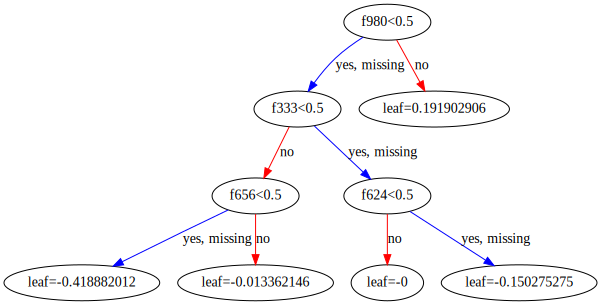

In [30]:
import graphviz
xgb.to_graphviz(model)